# Pre-Processing

In this notebook we will use what we learned in lab 03 about forming the data, the end result is a dataset that we can feed weka to test models on.

### So we will:

1. [Load the dataset](#chapter1)
2. [Split the text into sentences](#chapter2)
3. [Perform sentiment analysis on the sentences](#chapter3)
4. [Include statistical features](#chapter4)
5. [Resample the data to 150 points](#chapter5)
6. [Store it in a row of a dataframe](#chapter6)
7. [Export it to a csv](#chapter7)

<br> <br>

In [1]:
# imports
import os
import pandas as pd
import numpy as np

from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
sia = SIA()

import nltk
#file for punkt splitter
nltk.download('punkt');
#file for vader sentiment
nltk.download('vader_lexicon');

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"]=20,20
%matplotlib inline

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\emiel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\emiel\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


<br>

### 1: Load the dataset <a class="anchor" id="chapter1"></a>

In [2]:
dataset_path_true = os.path.join("sources", "ISOT", "True.csv")
dataset_path_fake = os.path.join("sources", "ISOT", "Fake.csv")

dataset_load_true = pd.read_csv(dataset_path_true, encoding='utf-8') # make sure to use the right encoding
dataset_load_fake = pd.read_csv(dataset_path_fake, encoding='utf-8') 

display(dataset_load_true.head())
display(dataset_load_fake.head())

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


<br>

### 2: Split the text into sentences <a class="anchor" id="chapter2"></a>

in lab 03 we used a big manual function, but for now we will use the nltk tokenizer in this one :)

In [3]:
def split_sentences(article_text):
    """Takes a string, returns a list of its individual sentences ()"""
    return pd.Series(nltk.tokenize.sent_tokenize(article_text))

sample_sentences = split_sentences(dataset_load_true.text[0])
display(sample_sentences.iloc[[0,1,-2,-1]])

0     WASHINGTON (Reuters) - The head of a conservat...
1     In keeping with a sharp pivot under way among ...
28    The package far exceeded the $44 billion reque...
29             The Senate has not yet voted on the aid.
dtype: object

<br>

### 3: Performing sentiment analysis <a class="anchor" id="chapter3"></a>


In [4]:
def get_scores(text: list, method='VADER'):
    if method == 'VADER':
        scores = text.apply(lambda s: sia.polarity_scores(s)['compound']) #list of compound score per sentence
    else:
        scores = None

    return scores

sample_scores = get_scores(sample_sentences)
print(sample_scores.iloc[[0,1,-2,-1]])

0    -0.4215
1    -0.4588
28    0.0000
29    0.0000
dtype: float64


<br>

### 4: Include statistical features <a class="anchor" id="chapter4"></a>


In [5]:
def get_stats(scores):
    stats = scores.describe()
    return stats

sample_stats = get_stats(sample_scores)
print(sample_stats)

count    30.000000
mean      0.076147
std       0.402857
min      -0.636900
25%      -0.077025
50%       0.000000
75%       0.318200
max       0.906200
dtype: float64


<br>

### 5: Resample the data <a class="anchor" id="chapter5"></a>



In [6]:
def resample_to_x(scores, scores_len, x = 200, to_dict = False):
    if scores_len <= x: #resample to higher (or same) res
        if scores_len > 1:
            slope = (x - 1)/ (scores_len - 1)
            new_indices = ['p_'+f'{int(slope * i):03}' for i in range(int(scores_len))]

            new_scores = scores[:]
            new_scores.index = new_indices

            new_series = pd.Series(index = ['p_'+f'{i:03}' for i in range(int(x))], dtype='float64')

            output = new_scores.combine_first(new_series)
            output = output.interpolate()
        elif scores_len == 1:
            output = pd.Series(data = scores[0], index = ['p_'+f'{i:03}' for i in range(int(x))], dtype='float64')
        else:
            output = pd.Series(data = None, index = ['p_'+f'{i:03}' for i in range(int(x))], dtype='float64')
            
    elif scores_len > x: #downscale ;(
        y = int(np.ceil(len(scores)/x)) # bin size 
        
        new_scores = [np.mean(i) for i in np.array_split(np.array(scores), x)]
        output = pd.Series(data = new_scores, index = ['p_'+f'{i:03}' for i in range(int(x))], dtype='float64')
        
    if not to_dict:
        return output
    else:
        return output.to_dict()
    
sample_interp = resample_to_x(sample_scores, sample_stats['count'])


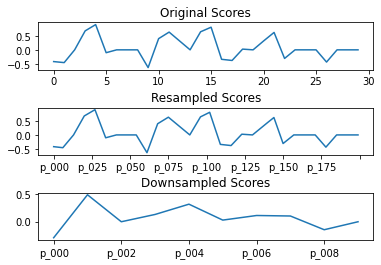

In [7]:
fig, axes = plt.subplots(nrows=3, ncols=1)
plt.subplots_adjust(hspace=0.8)

sample_scores.plot(ax=axes[0]);
axes[0].set_title('Original Scores');

sample_interp.plot(ax=axes[1]);
axes[1].set_title('Resampled Scores');

downsample_interp = resample_to_x(sample_scores, sample_stats['count'], x=10)
downsample_interp.plot(ax=axes[2]);
axes[2].set_title('Downsampled Scores');


<br>

### 6: Create the dataframe <a class="anchor" id="chapter6"></a>

In [8]:
def get_all(text, veracity: str, resample_size: int = 200):
    try: 
        # should all be dicts with the appropriate name
        sentences = split_sentences(text) # list
        scores = get_scores(sentences) #  list but ok, will be
        stats = get_stats(scores) # dict yes!
        scores_interp = resample_to_x(scores, stats['count'], resample_size, to_dict=True) # dict si (p_000 through p_resamplesize)
        v = {'veracity': veracity}
        v.update(stats)
        v.update(scores_interp)
        return pd.Series(v)
    except Exception as e:
        print("ERROR on text: \n"+text+"\n\n",stats['count'])
        raise e

# print(get_all(dataset_load_true.text[0], 1))

In [9]:
%%timeit

# this cell is for verifying that the method at least works on a small scale (8 instances)
# much quicker to debug than large scale (40k+ instances) ;(

resample_size = 200

cols = ['veracity', 'count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']
cols.extend(['p_'+f'{n:03}' for n in range(resample_size)])

miniset_true = dataset_load_true.head()
miniset_fake = dataset_load_fake.head()

miniset_prepro = pd.DataFrame(columns = cols)
miniset_prepro[cols] = miniset_true.text.apply(get_all, args=('T', resample_size));
miniset_prepro = pd.concat([miniset_prepro, (miniset_fake.text.apply(get_all, args=('F', resample_size)))], ignore_index=True)

miniset_prepro.iloc[[0,1,-2,-1]]
miniset_prepro.to_csv(os.path.join('out', 'mini_truefake.csv'), index=False)

185 ms ± 3.87 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [10]:
%%time # takes about 6 minutes on my device so I recommend skipping this cell :)

# resample_size = 200

# cols = ['veracity', 'count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']
# cols.extend(['p_'+f'{n:03}' for n in range(resample_size)])

# dataset_prepro = pd.DataFrame(columns = cols)

# print("We'll give it a shot!")
# dataset_prepro[cols] = dataset_load_true.text.apply(get_all, args=('T', resample_size));
# print("Woah, we're halfway there!")
# dataset_prepro = pd.concat([dataset_prepro, (dataset_load_fake.text.apply(get_all, args=('F', resample_size)))], ignore_index=True);
# print("Woah, livin' on a prayer")

# dataset_prepro = dataset_prepro[dataset_prepro['count'] != 0.0]

# display(dataset_prepro)

UsageError: Can't use statement directly after '%%time'!


<br>

### 7: Export to CSV <a class="anchor" id="chapter7"></a>

In [ ]:
# dataset_prepro.to_csv(os.path.join('out', 'truefake.csv'), index=False)